## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

# Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022

spark = SparkSession.builder \
                    .master("local") \
                    .appName("housing") \
                    .getOrCreate()

df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)

In [2]:
df.createOrReplaceTempView('df')

In [3]:
df.printSchema()

df.show(1, vertical = True)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

-RECORD 0----------------------
 longitude          | -122.23  
 latitude           | 37.88    
 housing_median_age | 41.0     
 total_rooms        | 880.0    
 total_bedrooms     | 129.0    
 population         | 322.0    
 households         | 126.0    
 median_income      | 8.3252   
 median_house_value | 452600.0 
 ocean_proximity    | NEAR BAY 
only showing top 1 row



типы данных изменять не нужно, они соответствуют столбцам.

# Предобработка данных

In [4]:
mv = df.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
mv.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



<AxesSubplot:>

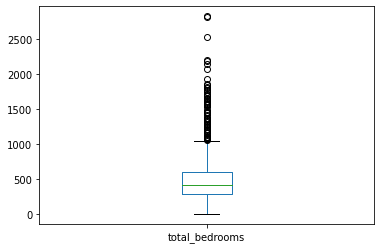

In [5]:
sample_size = 1000 
sample_data = df.select('total_bedrooms').sample(False, 0.1, seed=42).limit(sample_size).toPandas()

sample_data.plot(kind='box')

Эти значения я заполню медианой.

In [6]:
from pyspark.sql.functions import lit, when
median_value = df.selectExpr('percentile_approx(total_bedrooms, 0.5) as median').collect()[0]['median']
df = df.withColumn('total_bedrooms', when(df['total_bedrooms'].isNull(), lit(median_value)).otherwise(df['total_bedrooms']))

In [7]:
missing_values = df.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).toPandas()
missing_values.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,0,0,0,0,0,0,0,0,0


In [8]:
data1 = df.sample(True, 0.1, seed=42)
data1.toPandas().describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000,2114.000000
mean,-119.534063,35.610076,27.987228,2654.428098,542.511353,1431.135762,506.735572,3.890371,208353.923368
std,1.992566,2.147320,12.438636,2153.201129,410.982730,1081.720166,381.078286,1.887208,114340.031829
min,-124.190000,32.560000,2.000000,12.000000,4.000000,13.000000,7.000000,0.499900,27500.000000
25%,-121.740000,33.930000,18.000000,1469.250000,300.000000,809.250000,286.000000,2.603000,123125.000000
50%,-118.460000,34.240000,28.000000,2231.000000,451.000000,1195.000000,427.500000,3.603950,181850.000000
75%,-117.990000,37.707500,37.000000,3182.250000,664.000000,1749.750000,618.750000,4.766025,263875.000000
max,-114.600000,41.860000,52.000000,37937.000000,5471.000000,16122.000000,5189.000000,15.000100,500001.000000


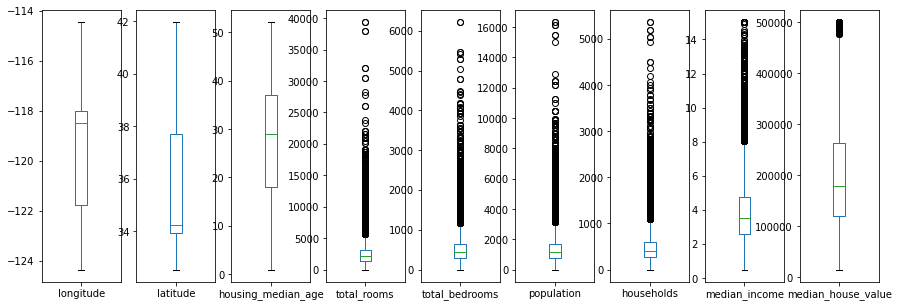

In [9]:
data = df.sample(True, 1.0, seed=42)
data = data.toPandas()
data.plot(kind = 'box', subplots = True, figsize = (15,5));

Есть множество выбросов, 

# Выборки

In [10]:
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count())

16418 4222


# OHE

In [11]:
categorical_cols = ['ocean_proximity']
numerical_cols  = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                  'population', 'households', 'median_income']
target = 'median_house_value'

indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols]) 
indexer.setHandleInvalid("keep")
indexer = indexer.fit(train_data)
train_data = indexer.transform(train_data)
test_data = indexer.transform(test_data)

cols = [c for c in df.columns for i in categorical_cols if (c.startswith(i))]
df.select(cols).show(3) 

+---------------+
|ocean_proximity|
+---------------+
|       NEAR BAY|
|       NEAR BAY|
|       NEAR BAY|
+---------------+
only showing top 3 rows



In [12]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
encoder = encoder.fit(train_data)
train_data = encoder.transform(train_data)
test_data = encoder.transform(test_data)

cols = [c for c in df.columns for i in categorical_cols if (c.startswith(i))]
df.select(cols).show(3) 

+---------------+
|ocean_proximity|
+---------------+
|       NEAR BAY|
|       NEAR BAY|
|       NEAR BAY|
+---------------+
only showing top 3 rows



In [13]:
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")
train_data = categorical_assembler.transform(train_data)
test_data = categorical_assembler.transform(test_data)

In [14]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                                                            outputCol="numerical_features")
train_data = numerical_assembler.transform(train_data)
test_data = numerical_assembler.transform(test_data)

In [15]:
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
standardScaler = standardScaler.fit(train_data)
train_data = standardScaler.transform(train_data)
test_data = standardScaler.transform(test_data)

In [16]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 
train_data = final_assembler.transform(train_data)
test_data = final_assembler.transform(test_data)

train_data.select(all_features).show(3)

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[2],[1.0])|     [-61.952887791441...|
|       (4,[2],[1.0])|     [-61.927977100733...|
|       (4,[2],[1.0])|     [-61.913030686308...|
+--------------------+-------------------------+
only showing top 3 rows



# Обучение моделей

In [17]:
lr = LinearRegression(labelCol=target, featuresCol='features')

model = lr.fit(train_data)

24/02/13 08:20:50 WARN Instrumentation: [807dcda5] regParam is zero, which might cause numerical instability and overfitting.
24/02/13 08:20:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/02/13 08:20:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/02/13 08:20:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/02/13 08:20:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
24/02/13 08:20:51 WARN Instrumentation: [807dcda5] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/02/13 08:20:52 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
24/02/13 08:20:52 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed


In [18]:
predictions_lr1 = model.transform(test_data)

predictedLabes = predictions_lr1.select("median_house_value", "prediction")
predictedLabes.show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 152990.3715510266|
|           50800.0|214967.38530553272|
|           58100.0|142714.15593254054|
|           68400.0| 132483.0438585477|
|           72200.0|164098.83915469842|
|           67000.0| 154443.3475532611|
|           81300.0|152868.89401633572|
|           70500.0|164579.10987743875|
|           60000.0|142736.46965603065|
|          109400.0|171312.66106254095|
|           74100.0|150617.92406168673|
|           74700.0|167873.14974967577|
|           90000.0|209844.44161841832|
|          104200.0|200499.70447348617|
|           74100.0|157152.61928658327|
|           67500.0|148318.58372470038|
|          103100.0| 47444.65998452902|
|           92500.0|166737.20305493847|
|          128100.0|222099.40397158777|
|           99600.0|187273.64443719992|
+------------------+------------------+
only showing top 20 rows



In [19]:
train_data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- ocean_proximity_idx: double (nullable = false)
 |-- ocean_proximity_ohe: vector (nullable = true)
 |-- categorical_features: vector (nullable = true)
 |-- numerical_features: vector (nullable = true)
 |-- numerical_features_scaled: vector (nullable = true)
 |-- features: vector (nullable = true)



2-ая модель

In [20]:
numerical_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
train_data_numerical = train_data.select(numerical_cols)
test_data_numerical = test_data.select(numerical_cols)

assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_featuress')
train_data_numerical = assembler.transform(train_data)
test_data_numerical = assembler.transform(test_data)

lr = LinearRegression(labelCol=target, featuresCol='numerical_featuress')
model = lr.fit(train_data_numerical)

predictions_lr2 = model.transform(test_data_numerical)

predictedLabes = predictions_lr2.select("median_house_value", "prediction")
predictedLabes.show()

24/02/13 08:20:55 WARN Instrumentation: [acad0027] regParam is zero, which might cause numerical instability and overfitting.


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|101397.02412162302|
|           50800.0|183325.89393630996|
|           58100.0|109609.16753139347|
|           68400.0| 80433.62265204126|
|           72200.0|129998.26626467239|
|           67000.0|120450.76353007555|
|           81300.0|118114.86731983256|
|           70500.0|130753.57019857969|
|           60000.0|110063.38701110613|
|          109400.0|118242.89485678216|
|           74100.0|117747.20196598629|
|           74700.0|134462.40087530483|
|           90000.0|176029.64032920683|
|          104200.0|166600.68830535607|
|           74100.0|123045.08642223617|
|           67500.0|113810.87810349511|
|          103100.0|-8400.804344731849|
|           92500.0|140926.28126488067|
|          128100.0|191273.72227955237|
|           99600.0|152718.59373970423|
+------------------+------------------+
only showing top 20 rows



# Анализ результатов

In [21]:
results = predictions_lr1.select(['prediction', 'median_house_value'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [ (float(i[0]), float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list)

metrics = RegressionMetrics(scoreAndLabels)
print("RMSE = %s" % metrics.rootMeanSquaredError)
print("R-squared = %s" % metrics.r2)
print("MAE = %s" % metrics.meanAbsoluteError)

RMSE = 68486.7300501659
R-squared = 0.6535582201164198
MAE = 49867.04607181885


In [22]:
results = predictions_lr2.select(['prediction', 'median_house_value'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [ (float(i[0]), float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list)

metrics = RegressionMetrics(scoreAndLabels)
print("RMSE = %s" % metrics.rootMeanSquaredError)
print("R-squared = %s" % metrics.r2)
print("MAE = %s" % metrics.meanAbsoluteError)

RMSE = 69212.86125283771
R-squared = 0.6461729709936699
MAE = 50866.55977305509


In [23]:
spark.stop()

*Вывод:* В ходе работы мне пришлось:
- использовать Spark для манипуляции с данными
- применять трансформеры из библиотеки MLlib для предобработки данных
- строить две модели линейной регрессии на разных наборах данных
- применять OHE и StandardScaler.

Обучив модель и оценив ее на двух видах данных: с категориальными столбцами и без, могу сказать, что лучше показывает себя модель на общих данных,т.е. на всех столбцах. Метрики RMSE и MAE на ней показывают себя лучше, чем на модели без категориальных столбцов.